# Robust linear regression

Noise isn't always Gaussian distributed: when our data have outliers, it is often more sensible to use a noise model which has heavy tails. Furthermore, the maximum likelihood estimate (which is what we are often computing when we perform linear regression) is only a point-estimate: the parameters of our linear regression will also be uncertain. Our task is to assign an uncertainty to the response variable ($Y$) at unobserved values of the input variable $X$. Accounting for parametric uncertainty using Bayesian inference for a more general linear model with heavy tails will allow us to address the above concerns.

Consider the following likelihood function

$$Y_{obs} = \alpha X + \beta + \epsilon$$

where 

$$\epsilon \sim \text{Student}(\nu)$$

is Student's t-distribution with $\nu >0$ degrees of freedom. We will use the following priors

$$\alpha \sim \text{Unif}(k_1,k_2)$$

$$\beta \sim \text{Unif}(k_3,k_4)$$

$$\nu \sim \text{HalfNormal}(0,k_5^2)$$

where the parameters $k$ are hyper-parameters (parameters of our prior). We will set these to be sensible constants, but in general we may place distributions over these as well. A rule of thumb is the higher up in the hierarchy we go in setting priors, the less our decisions matter on our inference.

We perform Hamiltonian Monte Carlo using Pymc3 to sample from the posterior distribution of this model.

Author: Juvid Aryaman

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import utls

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
utls.reset_plots()

## Make synthetic data

In [3]:
np.random.seed(1)
alpha_true = 2
beta_true = 3
dof_true = 2
size = 21

X = np.linspace(0,10,size) + np.random.uniform(0,0.5,size=size)
Y = alpha_true*X + beta_true + np.random.standard_t(dof_true,size=size)

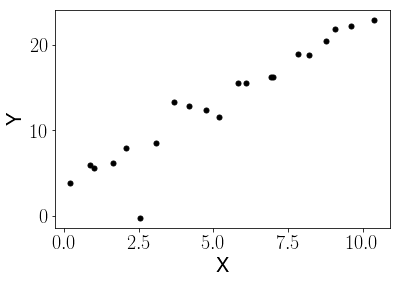

In [4]:
fig, ax = plt.subplots(1,1)
ax.plot(X,Y,'.k')
ax.set_xlabel('X')
ax.set_ylabel('Y');

We see we have an outlier at roughly $X=2.5$, which is coming from the data noise being generated by a Student t-distribution with a fairly low value of $\nu$.

## Hyper-parameters

Let's try and motivate our choice of hyperparameters for our priors $k_i$. Suppose we know the scale of the data is roughly unity (which could be achieved by rescaling the data), and expect (more or less) an increasing linear relationship from our domain knowledge. So let's use $k_1=k_3=-1$ and $k_2=k_4=10$.

For $k_5$, let's plot some Student t-distributions to get a feel for how the width varies with $\nu$. We know that as $\nu \rightarrow \infty$, Student's t-distribution converges onto a Gaussian.

In [5]:
import scipy.stats as ss

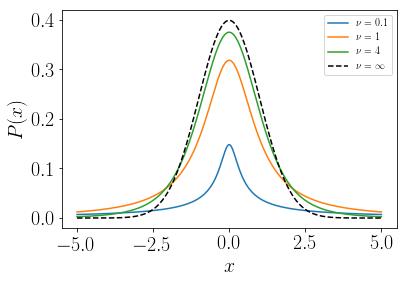

In [6]:
x_sp = np.linspace(-5,5,1000)

nu_vals = [0.1,1,4]

fig, ax = plt.subplots(1,1)
for nu in nu_vals:
    pdf = ss.t.pdf(x_sp,nu)
    ax.plot(x_sp, pdf, label = r'$\nu={}$'.format(nu))
pdf = ss.norm.pdf(x_sp,loc=0.0,scale=1.0)
ax.plot(x_sp,pdf,'--k',label=r'$\nu=\infty$')
ax.set_xlabel('$x$')
ax.set_ylabel('$P(x)$')
ax.legend(prop={'size':10});


So there's not much point in putting much mass above e.g. $\nu = 4$, because it all looks Gaussian in that area of parameter space, and we want some mass near 0 so we allow for potentially heavy tails. We need a strictly positive-valued distribution, so we've chosen a Half-Normal. Let's use $k_5=2$.

## Perform Bayesian inference with Pymc3 and Hamiltonian Monte Carlo

In [7]:
import pymc3 as pm
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.2


Add `export MKL_THREADING_LAYER=GNU` to `~/.bashrc` and restart Jupyter kernel if you have never installed pymc3 before

Declare the model

In [8]:
basic_model = pm.Model()
with basic_model:
    # Regression coefs
    alpha = pm.Uniform('alpha',-1,10)
    beta = pm.Uniform('beta',-1,10)
    
    # Expected value
    mu = alpha*X + beta
    
    dof = pm.HalfNormal('dof',sd=2)
    
    # Noisy observation with t-distributed noise
    Y_obs = pm.StudentT('Y_obs', nu=dof, mu=mu, observed=Y)
    
    #sigma = pm.HalfNormal('sigma',sd=10)
    #Y_obs = pm.Normal('Y_obs', sd=sigma, mu=mu, observed=Y)

Find the maximum a posteriori estimate of the parameters

In [9]:
map_estimate = pm.find_MAP(model=basic_model)

logp = -42.002, ||grad|| = 2.4167: 100%|██████████| 36/36 [00:00<00:00, 1133.43it/s]  


Perform inference

In [10]:
with basic_model:
    trace_ = pm.sample(3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 3500/3500 [00:07<00:00, 468.86it/s]


Discard burn-in and thin if necessary (it isn't here)

In [11]:
burn = 1000
thin = 1
trace = trace_[burn::thin]

Plot the marginals and the trace of the parameter value with iterations. Want fat hairy caterpillars for the plots on the right so that the chain is 'mixed' and samples are approximately independent after a few iterations.

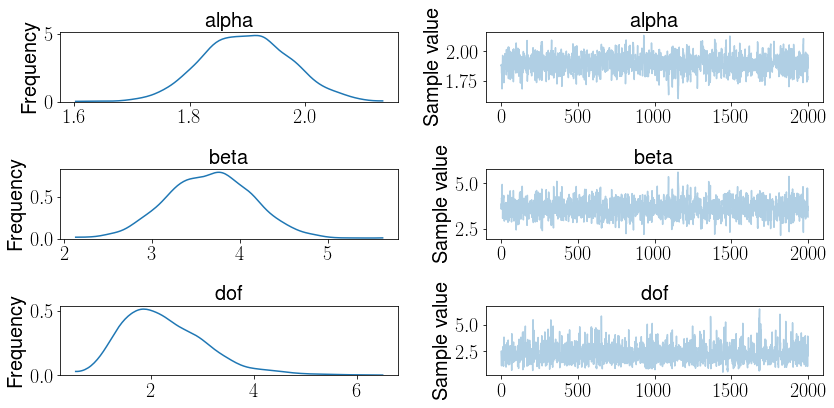

In [12]:
pm.plots.traceplot(trace);

Looking good! Let's quantify the autocorrelation in these trace plots to check that the chain has mixed.

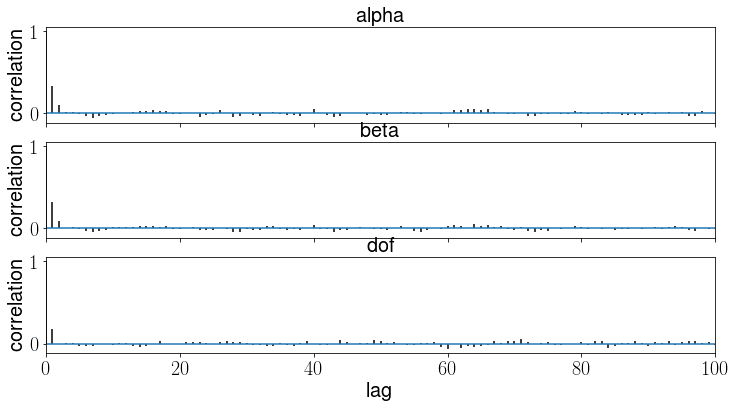

In [13]:
pm.plots.autocorrplot(trace);

Looking good!

Compute posterior distribution $P(\langle Y \rangle |\mathcal{D})$ by calculating $\alpha_i X + \beta_i$ where $\alpha_i$, $\beta_i$ are posterior samples

In [14]:
Y_post = np.einsum('i,j->ij',trace['alpha'],X) + trace['beta'][:,np.newaxis]

Get 95 Bayesian Confidence interval on $Y$

In [15]:
q_low = np.percentile(Y_post,2.5, axis=0)
q_high = np.percentile(Y_post,100-2.5, axis=0)

The above looks at parametric uncertainty in the mean. But it's also useful to have a measure of our total uncertainty in the value of $Y$, taking into account that the noise has a distribution of values. Let's compute confidence intervals on the noise, and then add this onto the mean to get a total measure of uncertainty.

In [16]:
bounds_95 = []
df_marginal = trace['dof']
for df in df_marginal:
    bounds_95.append(ss.t.ppf([0.025,1-0.025],df=df))
bounds_95 = np.array(bounds_95)

In [17]:
Y_low = Y_post + bounds_95[:,0][:,np.newaxis]
Y_low_perc = np.percentile(Y_low,2.5, axis=0)

Y_high = Y_post + bounds_95[:,1][:,np.newaxis]
Y_high_perc = np.percentile(Y_high,100-2.5, axis=0)

So `Y_low_perc` is $\epsilon_-$ which is the lower bound on the noise, taking into account parametric uncertainty, and `Y_high_perc` is $\epsilon_+$ which is the upper bound on the noise

array([  4.07649974,   5.31041733,   5.57531182,   6.80820284,
         7.60767096,   8.50291296,   9.53859665,  10.6361786 ,
        11.63142146,  12.71267058,  13.54617902,  14.74480368,
        15.23639364,  16.82095665,  16.96228   ,  18.51788603,
        19.22496338,  20.30558362,  20.85631248,  21.85771669,  23.37503864])

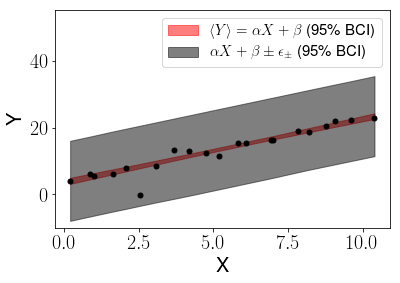

In [18]:
fig, ax = plt.subplots(1,1)
ax.plot(X,Y,'.k')
ax.plot(X, map_estimate['alpha']*X + map_estimate['beta'], label = 'MA')
ax.fill_between(X,q_low,q_high,color='red',alpha=0.5, label = r"$\langle Y \rangle = \alpha X + \beta$ (95\% BCI)")
ax.fill_between(X,Y_low_perc,Y_high_perc,color="black",alpha=0.5, label = r"$\alpha X + \beta \pm \epsilon_{\pm}$ (95\% BCI)")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_ylim([-10,55])
ax.legend();

So we see that all of our data is within the grey shaded region, we'd expect about 95% of our data to lie in there. The red region is our uncertainty in the mean trend, without noise.